In [1]:
%matplotlib inline
import autograd.numpy as np
import pylab as plt
import seaborn as snb

from scipy.optimize import minimize
from autograd import value_and_grad

from exercise4 import plot_with_uncertainty
from exercise4 import generate_samples
from exercise4 import add_colorbar

snb.set_style('darkgrid')
snb.set(font_scale=1.5)


# 02477 Bayesian Machine Learning: Gaussian processes

The purpose of this exercise is to
- become familiar with the squared exponential kernel and understand its parameters
- become familiar with Gaussian processes and learn to use them as prior distribution for unknown latent functions
- use Gaussian processes for regression

The exercise is divided into three parts:
- Part 1: The squared exponential kernel
- Part 2: Gaussian process regression on toy data set
- Part 3: Modeling the bike sharing dataset

# Part 1: Priors on functions and the squared exponential kernel

When we worked with parametric models such as linear regression and logistic regression, we assigned prior distributions on the weights $\mathbf{w}$ of the models. In contrast, we can think of Gaussian processes as prior distributions directly on the function space

\begin{align*}
y(x) \sim \mathcal{GP}\left(0 \, , \, k\left(\mathbf{x}, \mathbf{x}'\right)\right). \tag{1}
\end{align*}

The Gaussian process is completely specified by its mean and covariance function. Most often we take the mean function to be zero because we don't have any prior information on the mean function. 

The **covariance function** (or kernel function) $k(\mathbf{x}, \mathbf{x}')$ thus completely determines the a priori behaviour of the latent function $y$. Specically, the covariance function determines the covariance of the latent function $y$ when evaluated at two different inputs, i.e.

$$\begin{align*}
\text{cov}[y(\mathbf{x}), y(\mathbf{x}')] = k(\mathbf{x}, \mathbf{x}') \tag{2}
\end{align*}$$


The **squared exponential** covariance function is given by

\begin{align*} 
    k(\mathbf{x}_n, \mathbf{x}_m) = \kappa^2 \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right), \tag{3}
\end{align*}

where $\kappa > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponeniated quadratic kernel. 

The purpose of the first part is to become familiar with this covariance function and understand its properties. We will do this by generating and visualizing samples from a Gaussian process with the squared exponential kernel. 

Below you are given a vector $\mathbf{X}^p \in \mathbb{R}^{N}$ of $N = 100$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-6, 6\right]$. 

Let $y_n = y(x_n) \in \mathbb{R}$ be the value of the function $y$ evaluated at $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{y} = \left[y_1, y_2, \dots, y_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points of $\mathbf{X}^p$ 

The Gaussian process prior for $\mathbf{y}$ becomes

\begin{align*}
\mathbf{y} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right), \tag{4}
\end{align*}

where $\mathbf{K}$ is the kernel matrix.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


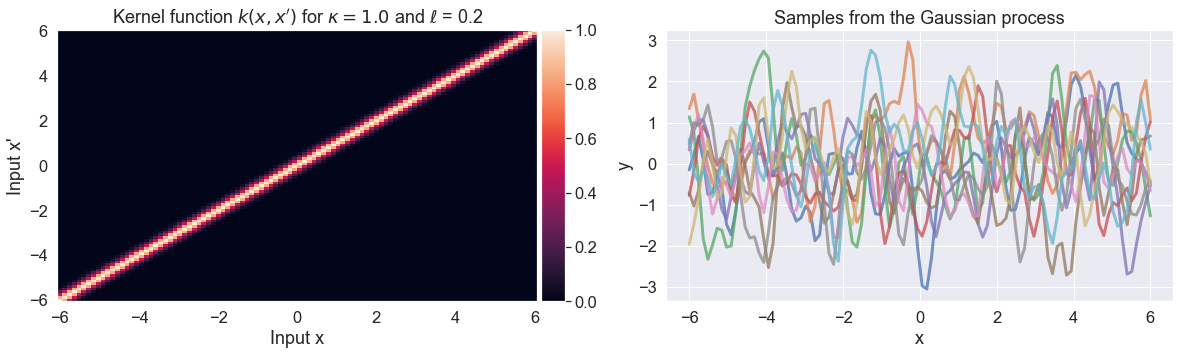

In [2]:
squared_exponential = lambda tau_squared, kappa, scale: kappa**2*np.exp(-0.5*tau_squared/scale**2)

import pdb

def se_kernel(X1, X2, theta, jitter=1e-8):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1     -- NxD matrix
    X2     -- MxD matrix
    theta  -- vector with 2 elements: [kappa, scale]
    jitter -- scalar
    
    returns NxM matrix    
    """
    # extract hyperparameters
    kappa, scale = theta[0], theta[1]

    # compute all the pairwise squared distances efficiently
    dists_squared = np.sum((np.expand_dims(X1, 1) - np.expand_dims(X2, 0))**2, axis=-1)
    
    # squared exponential covariance function
    K = squared_exponential(dists_squared, kappa, scale)
    
    # add jitter to diagonal for numerical stability
    if len(X1) == len(X2) and np.allclose(X1, X2):
        K = K + jitter*np.identity(len(X1))
    
    return K



# create an Nx1 vector of equidistant points in [-6, 6]
N = 100
Xp = np.linspace(-6, 6, N)[:, None]

# hyperparameters
kappa = 1
scale = 0.2

num_samples = 10

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
Kpp = se_kernel(Xp, Xp, theta=[kappa, scale])
im = ax[0].pcolormesh(Xp.flatten(), Xp.flatten(), Kpp, shading='auto')
ax[0].set(xlabel='Input x', ylabel="Input x'", title=f"Kernel function $k(x, x')$ for $\kappa = {kappa:2.1f}$ and $\ell$ = {scale:2.1f}")
ax[0].grid(False)
add_colorbar(im, fig, ax[0])

y_samples = generate_samples(0, Kpp, M=num_samples)
ax[1].plot(Xp, y_samples, alpha=0.75, linewidth=3);
ax[1].grid(True)
ax[1].set(xlabel='x', ylabel='y', title='Samples from the Gaussian process');


## **Questions**

### 1.1) Look at the left figure above and give an interpretation of the structure of kernel matrix.

*Hint: Compare the kernel values for pairs of points close to each other to pairs of points further apart

The closer the points are to each other, the more correlated they are. The covariance is reduced exponentially with the squared distance. This means that points close to each other often will be either all postive or negative.


### 1.2) Change the parameters $\kappa, \ell$ and explain how they affect the structure of the kernel (left panel)
$\kappa$ changes the magnitude of the corvariance between the points (correlation stays the same). This in turn allows for points further away from the mean (the graviational pull of points close by is large compared to the gravitational pull from the mean) or closer. 

$\ell$ changes the correlation accros the entire spectrum of points (so how correlated points far away from each other are). This eaither smoothens or sharpens the shape of the samples from the gaussian process.

### 1.3) Change the parameters $\kappa, \ell$ and explain how they affect the prior samples (right panel)
Same as above



The squared exponential kernel is an example of a **stationary** kernel, which means that the covariance function only depends on the difference between two points. Let $x_i$ and $x_j$ be two points in the input space and define $\tau = x_i - x_j$, then we can write

\begin{align*}
    k(x_i, x_j) = k(\tau) =  \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right), \tag{5}
\end{align*}


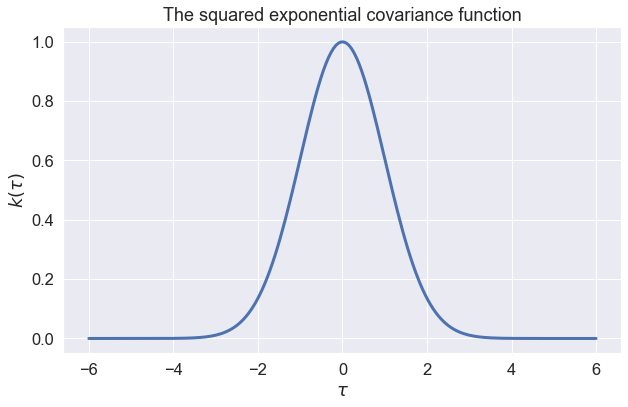

In [3]:
tau = np.linspace(-6, 6, 200)

kappa = 1
scale = 1

plt.figure(figsize=(10, 6))
plt.plot(tau, squared_exponential(tau**2, kappa=kappa, scale=scale), linewidth=3)
plt.title('The squared exponential covariance function')
plt.xlabel('$\\tau$')
plt.ylabel('$k(\\tau)$');


## **Questions**

#### Suppose the distance between two input points $x_i$ and $x_j$ is $\|\tau\| = \|x_i - x_j\| = d\cdot\ell$.

### 1.4) What is the covariance between the function values $y(x_i)$ and $y(x_j)$ for $d = 0, 1, 2, 3, 4, 5$ for $\kappa = 1$?
$$d=0 \rightarrow \mathrm{e}^{-\frac{d^2}{2}} = \mathrm{e}^{-\frac{0^2}{2}} = 1$$
$$d=1 \rightarrow \mathrm{e}^{-\frac{d^2}{2}} = \mathrm{e}^{-\frac{1^2}{2}} = \mathrm{e}^{-\frac{1}{2}}$$
$$d=2 \rightarrow \mathrm{e}^{-\frac{d^2}{2}} = \mathrm{e}^{-\frac{2^2}{2}} = \mathrm{e}^{-2}$$
$$d=3 \rightarrow \mathrm{e}^{-\frac{d^2}{2}} = \mathrm{e}^{-\frac{3^2}{2}} = \mathrm{e}^{-\frac{9}{2}}$$
$$d=4 \rightarrow \mathrm{e}^{-\frac{d^2}{2}} = \mathrm{e}^{-\frac{4^2}{2}} = \mathrm{e}^{-8}$$
$$d=5 \rightarrow \mathrm{e}^{-\frac{d^2}{2}} = \mathrm{e}^{-\frac{5^2}{2}} = \mathrm{e}^{-\frac{25}{2}}$$

Hint: Use eq. (5)

### 1.5) What can we say about the statistical relationship between $y(x_i)$ and $y(x_j)$ when $d \gg 3$?
They do not correlate at all - i.e. it would be a white noise process

### 1.6) What can we say in general about the function values $y(x_i)$ and $y(x_j)$ for points $x_i$ and $x_j$ that separated by more than a few lengthscales?
They are almost not correlated with each other



# Part 2: Non-linear regression using Gaussian processes

In this part, we will study how Gaussian processes can be used for non-linear regression. Assume we have a regression dataset $\mathcal{D} = \left\lbrace \mathbf{x}_i, t_i \right\rbrace_{i=1}^N$. We will adopt the following model

$$
\begin{align*}
t_n = y(\mathbf{x}_n) + e_n,
\end{align*}
$$

where $y(\mathbf{x})$ is assumed to be a Gaussian process. Assuming the noise $e_n$ is i.i.d. and Gaussian, the joint model for the training data becomes:

\begin{align*}
p(\mathbf{t}, \mathbf{y}) = \mathcal{N}\left(\mathbf{t}|\mathbf{y}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{y} | \mathbf{0}, \mathbf{K}\right)
\end{align*}

where $(\mathbf{K})_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$ is the covariance matrix. 
We will also use the squared exponential covariance function in this part. Thus, this model (when using  the squared exponential covariance function) has three hyperparameters in total: $\mathbf{\theta} = \left\lbrace \sigma, \kappa, \ell\right\rbrace$.

We will use $\mathbf{\theta}_K = \left\lbrace \kappa, \ell\ \right\rbrace$ to denote the hyperparameters of the kernel $K$ and $\mathbf{\theta}$ to denote all hyperparameters of the model.

Our goal is to compute the distributions $p(y^*|\mathbf{t})$ and $p(t^*|\mathbf{t})$ for some new input point $\mathbf{x}^*$.









Below you are given a template for a function called **posterior**, which computes the posterior distribution of the function values $y(X_p)$ for inputs $X_p$ conditioned on the traning data $\mathcal{t}$.

In [4]:
def posterior(Xp, X, t, kernel_function, theta):
    """ returns the posterior distribution of y evaluated at each of the points in Xp conditioned on (X, t)
    
    Arguments:
    Xp               -- PxD prediction points
    X                -- NxD input points
    t                -- Nx1 observed values 
    kernel_function  -- kernel function of the form k(X1, X2, theta)
    theta            -- vector of hyperparameters
    
    returns:
    mu               -- Px1 mean vector
    Sigma            -- PxP covariance matrix
    """

    # extract hyperparameters
    sigma = theta[0]
    theta_K = theta[1:]
    
    # prepare relevant matrices
    K = kernel_function(X, X, theta=theta_K)
    k = kernel_function(Xp, X, theta=theta_K)
    Kp = kernel_function(Xp, Xp, theta=theta_K)
    
    # Insert your solution for task 2.1 below
    C = K + sigma**2*np.identity(len(X))
    mu = np.dot(k, np.linalg.solve(C, t))
    Sigma = Kp - np.dot(k, np.linalg.solve(C, k.T))
    
    return mu, Sigma


# sanity check that your implementation returns the correct shapes
Xp = np.linspace(-3, 9, 100)[:, None]
mu_check, Sigma_check = posterior(Xp, np.zeros((0, 1)), np.zeros((0, 1)), se_kernel, [0.5, 1, 1])
assert mu_check.shape == (100, 1), "The dimensions of the posterior mu are wrong, check implementation"
assert Sigma_check.shape == (100, 100), "The dimensions of the posterior Sigma are wrong, check implementation"


**Question** 

2.1) Complete the implementation of the function **posterior** above.

Hints:
- Look at eq. (6.62), (6.66) and (6.67) in Bishop
- The function above computes the posterior $p(y^*|t, x^*)$ and not $p(t^*|t, x^*)$. Therefore, the noise variance $\sigma^2 = \beta^{-1}$ should not be included in $c$ as done in eq. (6.67)

Below you are given a simple toy data set $\mathcal{D} = \left\lbrace x_n, y_n \right\rbrace_{n=1}^N$ for $N = 50$ and we'll now fit a Gaussian process regression model to it.


In [142]:
# load data
data = np.load('./Data/data_exercise4.npz')
N = data['N']
Xtrain = np.concatenate((data['X'],data['X']+12),axis=0)
ttrain = np.concatenate((data['y'],-data['y']),axis=0)


Xtrain = np.concatenate((np.linspace(-3,7,48),np.array([9.4,9.5,9.6,9.7]),np.linspace(14,22,28)),axis=0)
Xtrain = Xtrain[:,None]
def func_gene(x):
    return 0.30*x + np.sin(x*1.7) - 1/40*x**2

ttrain = func_gene(Xtrain) + np.random.normal(0,0.40,(80,1))

Xp = np.linspace(-5, 24, 100)[:, None]

# function for plotting
def plot_data(ax):
    ax.plot(Xtrain, ttrain, 'k.', markersize=12, label='Data')
    ax.grid(True)
    ax.set_xlabel('Input $x$')
    ax.set_ylabel('Response $t$')
    ax.legend()



In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

def plot_with_uncertainty(ax, Xp, mu, Sigma, sigma, color='r', color_samples='b', title="", num_samples=0):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma) + sigma**2)
    
    

    
    # plot distribution
    ax.plot(Xp, func_gene(Xp), color='black', label='Generator',linestyle='--')
    ax.plot(Xp, mean, color=color, label='Mean')
    ax.plot(Xp, mean + 2*sigma, color='blue', linestyle='--',linewidth=0)
    ax.plot(Xp, mean - 2*sigma, color='blue', linestyle='--',linewidth=0)
    ax.plot(Xp, mean + 2*(std-sigma), color=color, linestyle='--',linewidth=0)
    ax.plot(Xp, mean - 2*(std-sigma), color=color, linestyle='--',linewidth=0)
    ax.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color='grey', alpha=0.2, label='Total')
    ax.fill_between(Xp.ravel(), mean - 2*sigma, mean + 2*sigma, color='blue', alpha=0.1, label='Aleatoric')
    ax.fill_between(Xp.ravel(), mean - 2*(std-sigma), mean + 2*(std-sigma), color=color, alpha=0.25, label='Epistemic')
    
    
    # generate samples
    ##if num_samples > 0:
     #   fs = generate_samples(mu, Sigma, num_samples)
     #   ax.plot(Xp, fs, color=color_samples, alpha=.25)
    
    ax.set_title(title)

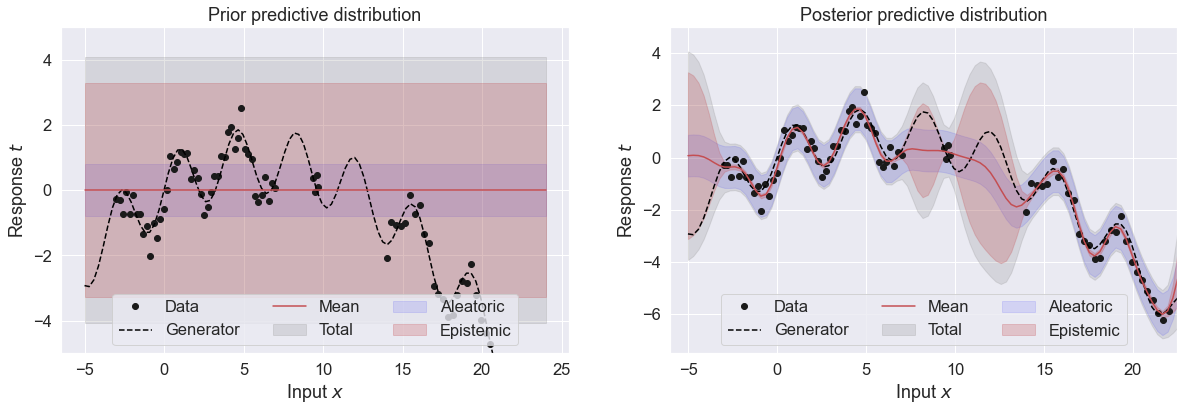

In [150]:
# hyperparameters
kappa = 2
scale = 1.
sigma = 0.4
theta = [sigma, kappa, scale]

# prior mean and covariance
mu_prior, Sigma_prior = posterior(Xp, np.zeros((0, 1)), np.zeros((0, 1)), se_kernel, theta)

# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, Xtrain, ttrain, se_kernel, theta)
    
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xp, mu_prior, Sigma_prior, sigma, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=3)
ax[0].set_ylim((-5, 5))
plot_data(ax[1])
plot_with_uncertainty(ax[1], Xp, mu_post, Sigma_post, sigma, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=3)
ax[1].set_ylim((-7.5, 5));
ax[1].set_xlim((-6, 22.5));
ax[1].set_xlim((-6, 22.5));

The left figure above shows 30 samples from the prior distribution along with the mean and 95% interval from the prior predictive distribution, whereas the right figure shows the same quantities for the posterior distribution.


## **Questions**


### 2.2) How does the prior and posterior differ in: a) regions close to the data points? b) in regions far from the data point? 
They are very similar in areas far away from our observations (observations does not affect this area). But close by data the posterior distribution is shaped accordingly to data (has learned from data)


### 2.3) Can you explain this behaviour using the equations for the posterior mean and covariance (and what you saw in part 1)?
The posterior mean is given by:
$$m(x_{N+1}) = k^TC_N^{-1}t$$
and posterior covariance:
$$c-k^TC_N^{-1}k$$
$k$ is the covariance between new datapoints and the training datapoints. With the kernel used we say, that observations far away from each has very low to no covariance. This mean in turn that $k$ is close to the zero-vector, which means the mean goes toward zero when away from the observations, the covariance goes towards $c$ (inherent covariance between predictions - same as prior), which with 0 mean looks like prior. 


### 2.4) Visualize the prior covariance matrix (Sigma_prior) and posterior covariance matrix (Sigma_post) side-by-side as images and comment on what you see
Covariance for posterior for observations close to the training points is almost zero (relative to those observations far away from the training points) - i.e. closer to white noise (not visible because we are looking at the posterior and not predictive distribution). To some extend it means that we have modelled the data.

### 2.5) Change the values of kappa and scale and explain how it affects the prior and posterior. For example, what happens if you choose the lengthscale $\ell$ to be either 0.25, 1, or 5 while keeping $\kappa = 1$ and $\sigma = \frac12$? Do similar experiments with $\sigma$ and $\kappa$.
Reducing $\kappa$ will reduce the prior covariance, which means we do not model data as close, which means the covaraince for the posterior is still there (however to a lower degree) for observations close to the training data. Increasing $\kappa$ will greatly increase covaraince for prior. Posterior covariance close to the datapoints will still be close to zero, since data can explain most!

Reducing $\ell$ will make the posterior distribution around the datapoints much more sharp. The covariance matrix will be very slim along the diagonal (covariance is reduced greatly for points far away from each other). An increase would increase the covariance, making the posterior distribution more smooth (mean would not go to zero far away from training points, since they have to follow the covariance structure).

Reducing $\sigma$ will reduce the variance between the datapoints, thus reducing the uncertainty bound close by datapoints, but not far away from datapoints. Increasing would do the oppposite





/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


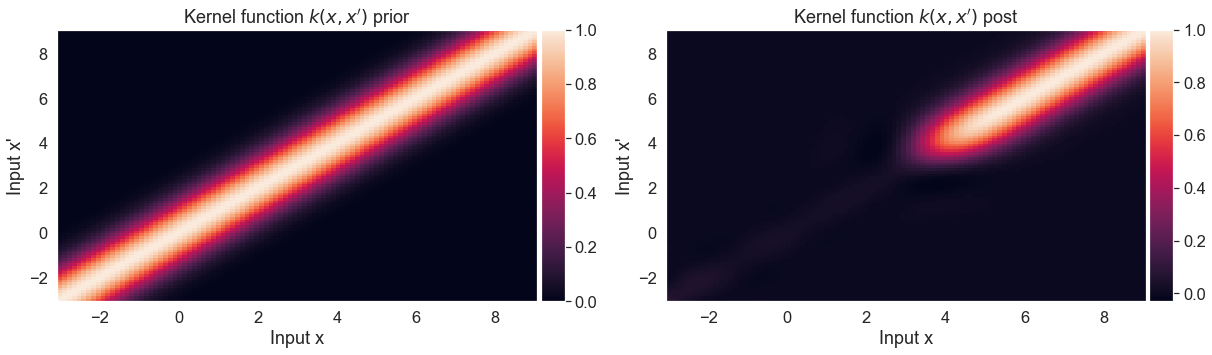

In [ ]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
im = ax[0].pcolormesh(Xp.flatten(), Xp.flatten(), Sigma_prior, shading='auto')
ax[0].set(xlabel='Input x', ylabel="Input x'", title=f"Kernel function $k(x, x')$ prior")
ax[0].grid(False)
add_colorbar(im, fig, ax[0])

im = ax[1].pcolormesh(Xp.flatten(), Xp.flatten(), Sigma_post, shading='auto')
ax[1].set(xlabel='Input x', ylabel="Input x'", title=f"Kernel function $k(x, x')$ post")
ax[1].grid(False)
add_colorbar(im, fig, ax[1])



Now, we will see how we can use the ***marginal likelihood*** to estimate the hyperparameters of the model. If we let $\mathbf{\theta} \in \mathbb{R}^K$ denote all of our hyperparameters, then the **evidence approximation** suggests that we can estimate $\mathbf{\theta}$ as follows

\begin{align*}
\hat{\mathbf{\theta}} = \arg\max\limits_{\mathbf{\theta}} \ln p(\mathbf{t}|\mathbf{\theta}),
\end{align*}

where $p(\mathbf{t}|\mathbf{\theta})$ is the marginal likelihood of the model (see eq. (6.69) in Bishop).

The cell below provides an implementation of the log marginal likelihood and a function to optimize using gradient-based optimization.

In [ ]:
def log_marginal_likelihood(X, t, kernel_function, theta):

    N = len(t)

    # extract hyperparameters
    sigma = theta[0]
    theta_K = theta[1:]
    
    # prepare kernels
    K = kernel_function(X, X, theta_K)
    C = K + sigma**2*np.identity(N)

    # compute Cholesky decomposition
    L = np.linalg.cholesky(C)
    v = np.linalg.solve(L, t)

    # compute log marginal likelihood
    logdet_term = np.sum(np.log(np.diag(L)))
    quad_term =  0.5*np.sum(v**2)
    const_term = -0.5*N*np.log(2*np.pi)
    return const_term - logdet_term - quad_term

def optimize_hyperparameters(X, t, kernel_function, theta_init):

    # define optimization objective as the negative log marginal likelihood
    objective = lambda th: -log_marginal_likelihood(X, t, kernel_function, th)

    # optimize using gradients
    res = minimize(value_and_grad(objective), theta_init, jac=True)

    # check for success
    if not res.success:
        print('Warning: optimization failed!')

    # return resultss
    theta = res.x
    return theta


Let's run it on our toy dataset:

In [ ]:
# optimize
theta_hat = optimize_hyperparameters(Xtrain, ttrain, se_kernel, theta_init=[1,1,1])

# extract individual hyperparameters
sigma_hat, kappa_hat, scale_hat = theta_hat

# print
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')
print(f'\tkappa: {kappa_hat:3.2f}')
print(f'\tscale: {scale_hat:3.2f}')


Estimated hyperparameters
	sigma: 0.59
	kappa: 2.92
	scale: 1.82


(-9.0, 9.0)

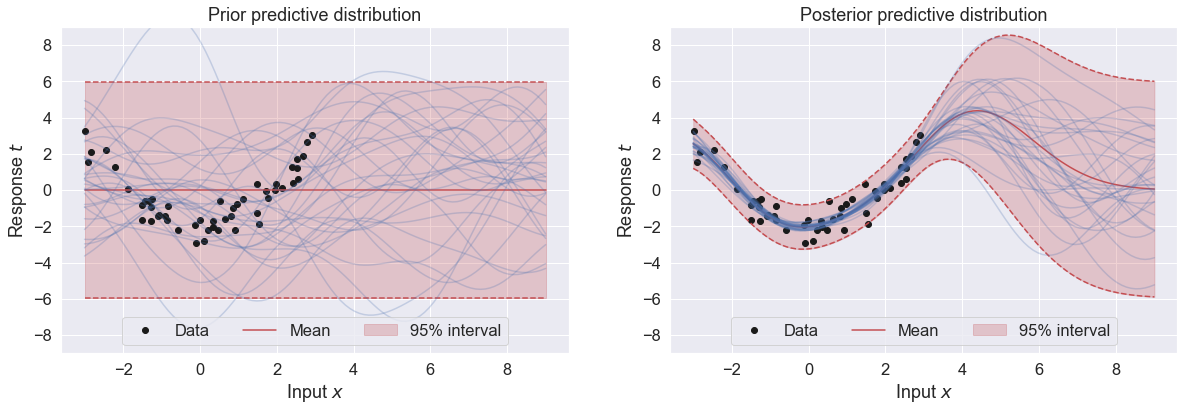

In [49]:
# prior mean and covariance
mu_prior, Sigma_prior = posterior(Xp, np.zeros((0, 1)), np.zeros((0, 1)), se_kernel, theta_hat)

# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, Xtrain, ttrain, se_kernel, theta_hat)
    
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xp, mu_prior, Sigma_prior, sigma_hat, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=3)
ax[0].set_ylim((-9, 9))
plot_data(ax[1])
plot_with_uncertainty(ax[1], Xp, mu_post, Sigma_post, sigma_hat, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=3)
ax[1].set_ylim((-9, 9))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


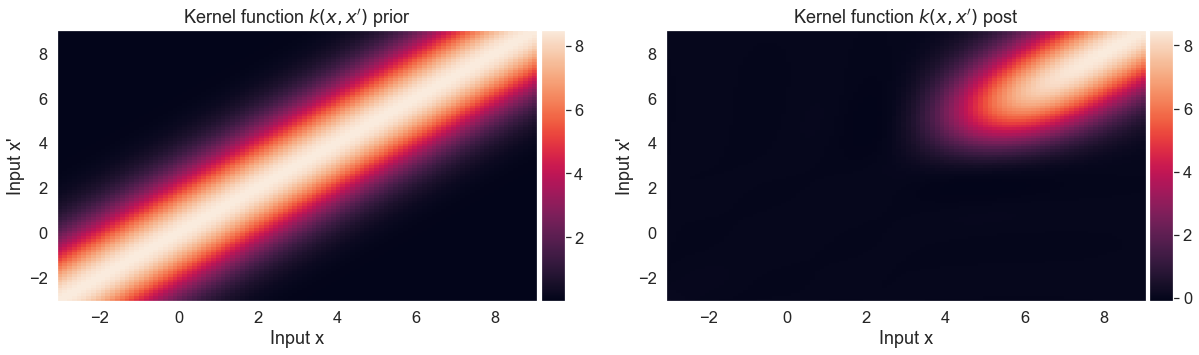

In [50]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
im = ax[0].pcolormesh(Xp.flatten(), Xp.flatten(), Sigma_prior, shading='auto')
ax[0].set(xlabel='Input x', ylabel="Input x'", title=f"Kernel function $k(x, x')$ prior")
ax[0].grid(False)
add_colorbar(im, fig, ax[0])

im = ax[1].pcolormesh(Xp.flatten(), Xp.flatten(), Sigma_post, shading='auto')
ax[1].set(xlabel='Input x', ylabel="Input x'", title=f"Kernel function $k(x, x')$ post")
ax[1].grid(False)
add_colorbar(im, fig, ax[1])




## **Questions**

### 3.1) Comment on the quality of the fit. Does it seem reasonable?
It seems fairly reasonable!

### 3.2) If we were to fit the three hyperparameters using 5-fold cross-validation and a grid search rather than using the marginal likelihood, how many times would we have to train the model? Assume we would 10 different values for each hyperparameter.
We would have $10^3$ different hyperparameter combinations, all having to be fitted 5 times, so 5000 times.



# Part 3: Analysing the bike sharing data set

In this section, your task is to fit a GP regression model (with squared exponential kernel) to a subset of the bike sharing dataset (Source: [https://ride.capitalbikeshare.com/system-data](https://ride.capitalbikeshare.com/system-data)). The dataset consists of the number of rented bikes in 2011.

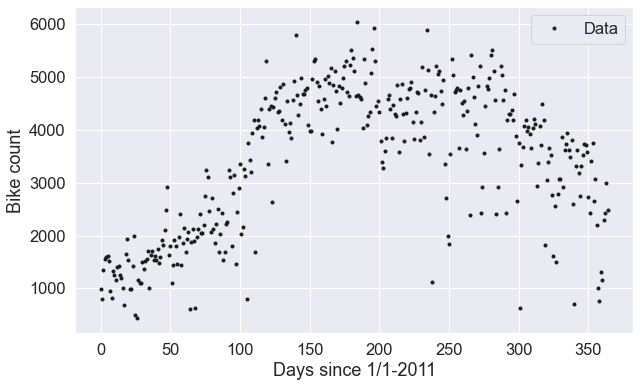

In [51]:
data = np.load('./Data/data_exercise4b.npz')
day = data['day']
bike_count = data['bike_count']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');


**Questions**

### 3.1) Log-transform the bike counts, remove the mean and scale to unit variance. Plot the preprocessed data set.

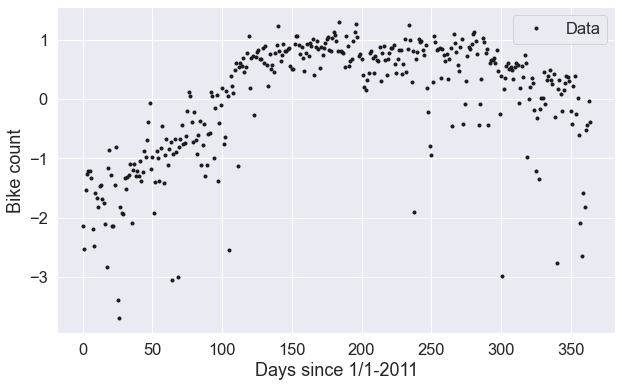

In [99]:
### Solution 3.1
bike_count = data['bike_count']
bike_count = np.log(bike_count)
bike_log_mean = np.mean(bike_count)
bike_log_std = np.sqrt(np.var(bike_count))
bike_count = (bike_count-bike_log_mean)/(bike_log_std)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');

### 3.2) Estimate the hyperparameters of a Gaussian process regression model with a squared exponential kernel from the preprocessed data (the optimization process might take a couple minutes to run). Report the estimates values of each hyperparameter.

In [71]:
### Solution 3.2
# optimize
theta_hat = optimize_hyperparameters(day, bike_count, se_kernel, theta_init=[1,1,50.])

# extract individual hyperparameters
sigma_hat, kappa_hat, scale_hat = theta_hat

# print
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')
print(f'\tkappa: {kappa_hat:3.2f}')
print(f'\tscale: {scale_hat:3.2f}')



Estimated hyperparameters
	sigma: 0.57
	kappa: 1.08
	scale: 78.63


### 3.3) Compute and visualize the predictive distribution for the interval $$\text{day} \in \left\lbrace 0, 1, 2, \dots, 370 \right\rbrace$$.

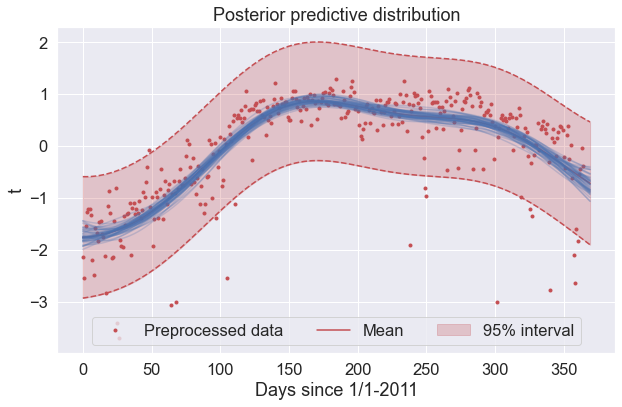

In [78]:
### Solution 3.3
# days for predictions
Xp = np.arange(0, 370)[:, None]

# compute posterior of y for all days in interval [0, 364]
mu_post, Sigma_post = posterior(Xp, day, bike_count, se_kernel, theta_hat)

# visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'r.', label='Preprocessed data')
plot_with_uncertainty(ax, Xp, mu_post, Sigma_post, sigma_hat, title='Posterior predictive distribution', num_samples=50)
ax.legend(loc='lower center', ncol=3)
ax.set(xlabel='Days since 1/1-2011', ylabel='t');

### 3.4) The observation model $p(t|y) = \mathcal{N}(t(x)|y(x), \sigma^2)$ assumes the additive noise is **isotropic** and **identically distributed** for all observations. Is that a reasonable assumption for this data set?
No for most areas it seems like the model mostly undershoots the data points.

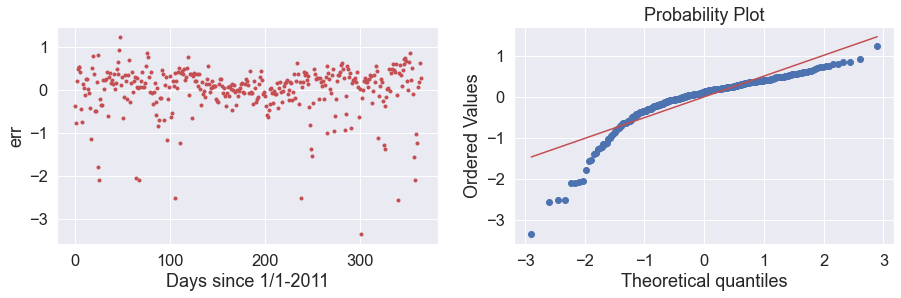

In [98]:
import scipy.stats as stats
# generate samples from posterior disitrbution
fs = generate_samples(mu_post[0:365], Sigma_post[0:365,0:365], num_samples)

#Get mean fit
fsmean = np.mean(fs,axis=1)

#Get errors
err = bike_count.flatten()-fsmean

# visualize
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(day, err, 'r.', label='Preprocessed data')
ax[0].set(xlabel='Days since 1/1-2011', ylabel='err');
stats.probplot(err, dist="norm", plot=ax[1]);

3.5) **Optional** Generate 50 samples from the posterior in the interval [0, 370], map them back to the original measurement space and plot them on top of the original dataset

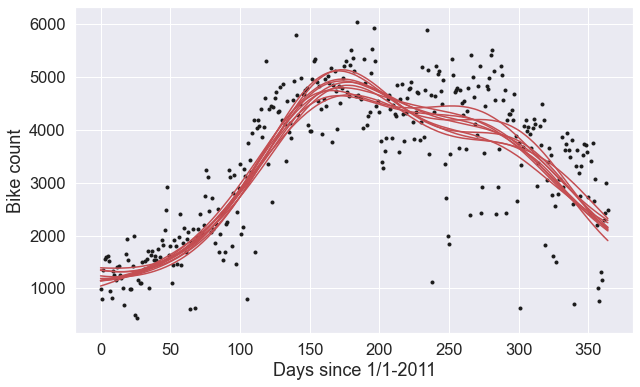

In [104]:
# solution 3.5
fs_org = np.exp(fs*bike_log_std + bike_log_mean)

#plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, data['bike_count'], 'k.', label='Data')
ax.plot(day, fs_org, 'r-', label='Fits')
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');